In [17]:
import os
import numpy as np
from datetime import datetime, timedelta, timezone
import xarray as xa
import matplotlib.pyplot as plt
from utils import setup_cmap
from matplotlib.colors import LinearSegmentedColormap
import cartopy.crs as ccrs
from pylibs.plot_utils import set_size
os.environ["TZ"] = "UTC"

In [2]:
savedir = '/glade/work/swei/projects/caliop_opr'
# infile = '/glade/derecho/scratch/swei/Dataset/input/obs/caliop_l2_extcoeff/obs.caliop_l2_extcoeff.2019072204.nc4'
infile = '/glade/work/swei/projects/caliop_opr/JEDI-ACE/output/caliop_merra2/hofx/f00/caliop_l2_extcoeff/hofx.sub.2pe.caliop_l2_extcoeff.2019072206.nc4'

In [3]:
def avg_horz_data(data, N):
    if len(data.shape)==2:
        nAlts = data.shape[1]
        nProfiles = data.shape[0]
        nOutProfiles = np.floor(nProfiles/N)
        out = np.zeros((int(nOutProfiles), int(nAlts)))
        for i in range(0, int(nOutProfiles) - 1):
            out[i, :] = np.nanmean(data[i*N:(i+1)*N, :], axis=0)
    elif len(data.shape)==1:
        nProfiles = data.shape[0]
        nOutProfiles = int(np.floor(nProfiles/N))
        out = np.zeros((nOutProfiles))
        for i in range(0, nOutProfiles - 1):
            out[i] = np.nanmean(data[i*N:(i+1)*N], axis=0)
    return out

def uniform_alt_2(max_altitude, old_altitude_array):
    # https://github.com/NASA-DEVELOP/VOCAL/blob/15182377cd9d7de1c03b123e3bbe15b0e959ac80/calipso/plot/uniform_alt_2.py
    D_ALT = 0.03  # spacing is 30 m
    # Altitude indices for high res altitude region (region 2):
    # 288:576
    MID_RES_TOP = 288
    MID_RES_BOT = 576
    alt2 = old_altitude_array[MID_RES_TOP:MID_RES_BOT]
    new_num_bins = int(np.ceil((max_altitude-alt2[0])/D_ALT))
    new_length = int(new_num_bins + len(alt2))
    new_alt = np.zeros(int(new_length))
    new_alt[int(new_num_bins):int(new_length)] = alt2
    upper_altitudes =  (np.arange(new_num_bins) + 1.)*D_ALT
    new_alt[:int(new_num_bins)] = new_alt[int(new_num_bins)] + upper_altitudes[::-1]
    return new_alt

def regrid_lidar(alt, inMatrix, new_alt, method = 'linear'):
    # https://github.com/NASA-DEVELOP/VOCAL/blob/15182377cd9d7de1c03b123e3bbe15b0e959ac80/calipso/plot/regrid_lidar.py
    interpFunc = interpolate.interp1d(alt[::-1], inMatrix[::-1,:], kind=method, 
                                      axis=0, bounds_error=False)
    return interpFunc(new_alt)

In [4]:
cmap = plt.cm.jet.copy()
cmap.set_under("white")

In [5]:
meta_ds = xa.open_dataset(infile, group='MetaData')
obsv_ds = xa.open_dataset(infile, group='ObsValue')
hofx_ds = xa.open_dataset(infile, group='hofx')

In [6]:
nlev = meta_ds.Level.size
nloc = meta_ds.Location.size
npro = int(meta_ds.Location.size / nlev)
nchl = meta_ds.Channel.size
lats = meta_ds['latitude'].data
lons = meta_ds['longitude'].data
date = meta_ds['dateTime'].data
pres = meta_ds['pressure'].data
profidx = meta_ds['sequenceNumber'].data
dz = meta_ds['atmosphereLayerThicknessZ'].data
alt = meta_ds['height'].data

In [7]:
obsv = obsv_ds['extinctionCoefficient'].data
obsv = np.where((obsv < 0.)|(obsv > 1.25), np.nan, obsv)
hofx = hofx_ds['extinctionCoefficient'].data
hofx = np.where((obsv < 0.)|(obsv > 1.25), np.nan, hofx)

In [8]:
data_dict = {
    'obsv': (['Location', 'Channel'], obsv),
    'hofx': (['Location', 'Channel'], hofx),
    'dateTime': (['Location'], date),
    'pres': (['Location'], pres),
    'lat': (['Location'], lats),
    'lon': (['Location'], lons),
    'profidx': (['Location'], profidx),
}
coord_dict = {
    'Level': alt,
    'Location': np.arange(nloc),
    'Channel': np.arange(nchl),
}

In [9]:
tmpds = xa.Dataset(data_dict, coords=coord_dict)
tmpds = tmpds.sortby(tmpds['profidx'])

In [10]:
tmpds['hofx'] = (('Profile', 'Level', 'Channel'), tmpds['hofx'].values.reshape(npro, nlev, nchl))
tmpds['obsv'] = (('Profile', 'Level', 'Channel'), tmpds['obsv'].values.reshape(npro, nlev, nchl))
tmpds['pres'] = (('Profile', 'Level'), tmpds['pres'].values.reshape(npro, nlev))
tmpds['plat'] = (('Profile'), tmpds['lat'].values[::399])
tmpds['plon'] = (('Profile'), tmpds['lon'].values[::399])
tmpds['p_dt'] = (('Profile'), tmpds['dateTime'].values[::399])
tmpds = tmpds.assign_coords(Profile=np.arange(npro))

In [11]:
sort_idx = np.argsort(tmpds['pres'].values, axis=1)
tmp_prof = np.arange(sort_idx.shape[0])[:, None]
sorted_pres = tmpds['pres'].values[tmp_prof, sort_idx]
sorted_hofx = tmpds['hofx'].values[tmp_prof, sort_idx, :]
sorted_obsv = tmpds['obsv'].values[tmp_prof, sort_idx, :]
tmpds['pres'] = (('Profile', 'Level'), sorted_pres)
tmpds['hofx'] = (('Profile', 'Level', 'Channel'), sorted_hofx)
tmpds['obsv'] = (('Profile', 'Level', 'Channel'), sorted_obsv)

In [12]:
obsv_aod = np.nansum(tmpds['obsv'] * dz[None, :, None] * 1e-3, axis=1)
hofx_aod = np.nansum(tmpds['hofx'] * dz[None, :, None] * 1e-3, axis=1)

In [13]:
plot_ds = tmpds.sel(Level=slice(15000, -200)) #, Profile=slice(223, 324))

In [14]:
xvals = []
xstrs = []
for i in np.round(np.linspace(0, plot_ds.Profile.data[-1] - plot_ds.Profile.data[0], 10, dtype=np.int32)):
    ll_idx = i + plot_ds.Profile.data[0]
    xvals.append(ll_idx)
    if len(xvals) == 1:
        xstrs.append('Lat: %.2f \n Lon: %.2f' % (tmpds.plat[ll_idx], tmpds.plon[ll_idx]))
    else:
        xstrs.append('%.2f \n %.2f' % (tmpds.plat[ll_idx], tmpds.plon[ll_idx]))

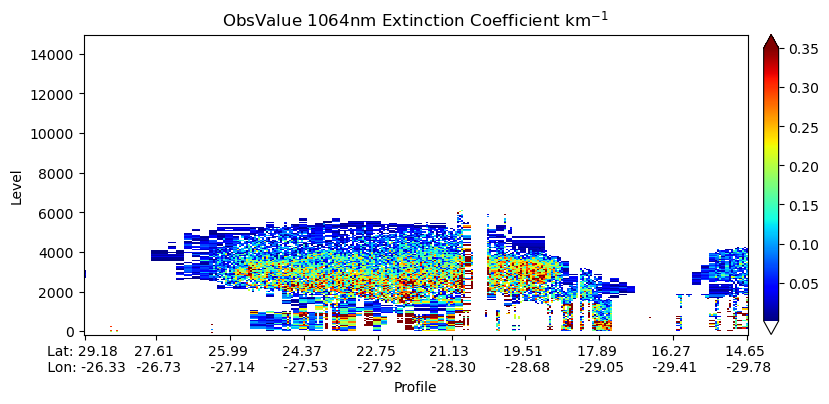

In [31]:
fig, ax = plt.subplots()
p = plot_ds.obsv.sel(Channel=1).plot(
    ax=ax,
    x='Profile',
    cmap=cmap,
    vmin=0.001,
    vmax=0.35,
    # size=4,
    # aspect=2.5,
    add_colorbar=True,
    cbar_kwargs={
        # 'format': "%.e",
        'label': None,
        'pad': 0.02
    },
)
set_size(8, 3, l=0.1, b=0.1, t=0.9, r=1.)
p.axes.set_title(r'ObsValue 1064nm Extinction Coefficient km$^{-1}$')
p.axes.set_xticks(xvals)
p.axes.set_xticklabels(xstrs)
p.figure.savefig(f'{savedir}/obsv1064.png', dpi=600)

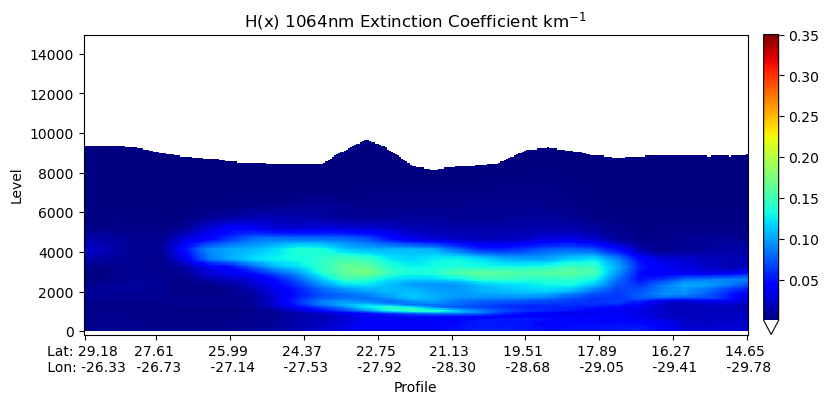

In [29]:
p = plot_ds.hofx.sel(Channel=1).plot(
    x='Profile',
    cmap=cmap,
    vmin=0.001,
    vmax=0.35,
    size=4,
    aspect=3.5,
    add_colorbar=True,
    cbar_kwargs={
        # 'format': "%.e",
        'label': None,
        'pad': 0.02
    },
)
set_size(8, 3, l=0.1, b=0.1, t=0.9, r=1.)
p.axes.set_title(r'H(x) 1064nm Extinction Coefficient km$^{-1}$')
p.axes.set_xticks(xvals)
p.axes.set_xticklabels(xstrs)
p.figure.savefig(f'{savedir}/hofx1064.png', dpi=600)

In [67]:
plot_ds.p_dt.max(), plot_ds.p_dt.min()

(<xarray.DataArray 'p_dt' ()> Size: 8B
 array('2019-07-22T03:57:15.000000000', dtype='datetime64[ns]'),
 <xarray.DataArray 'p_dt' ()> Size: 8B
 array('2019-07-22T03:54:46.000000000', dtype='datetime64[ns]'))

In [63]:
np.isnan(plot_ds.hofx.data[1::2, :, 0])

True

In [68]:
ncfile = '/glade/work/swei/data/Reanalysis/MERRA-2/M2I3NXGAS/2019/07/MERRA2_400.inst3_2d_gas_Nx.20190722.nc4'
ds = xa.open_dataset(ncfile)

In [69]:
proj = ccrs.PlateCarree()
c_lon = plot_ds.plon.mean().data
c_lat = plot_ds.plat.mean().data

In [72]:
c_lon, c_lat

(array(-28.1148243), array(21.89776993))

In [70]:
colors = ["white", "tab:orange", "black"]
n_bins = 100
ccmap = LinearSegmentedColormap.from_list('here', colors, N=n_bins)

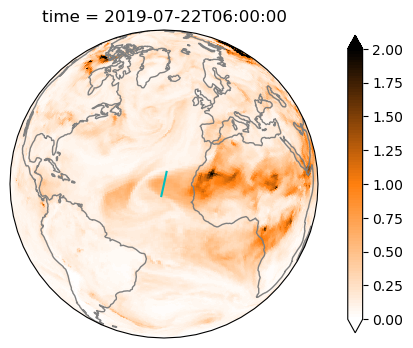

In [71]:
p = ds.AODANA.sel(time='2019-07-22 06:00:00').plot(
    vmin=0,
    vmax=2,
    size=4,
    aspect=1.6,
    add_colorbar=True,
    subplot_kws=dict(
        projection=ccrs.Orthographic(c_lon, c_lat),
    ),
    transform=ccrs.PlateCarree(),
    cmap=ccmap,
    cbar_kwargs=dict(
        label=None,
        pad=0.06,
        fraction=0.03,
    ),
)
# p.axes.gridlines(draw_labels=True)
p.axes.coastlines(color='grey')
plt.plot(plot_ds.plon.data[::50], plot_ds.plat.data[::50], 'c', ls='-', lw=1.5, marker='', zorder=5, transform=ccrs.PlateCarree())

In [47]:
p.figure.savefig(f'{savedir}/caliop_path.png', dpi=600)